**Import Required libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
%matplotlib inline

np.random.seed(2)
from shutil import copyfile
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D, MaxPooling2D, Add, Input, Activation, BatchNormalization, ZeroPadding2D, LeakyReLU
from keras.initializers import glorot_uniform
from keras.models import Model, load_model

from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

### Extract the data from zip files
- Extract the zip files
- Create the folder structure with train and test folders
- Copy the data from the 2 classes into train and test

In [5]:
import zipfile
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [8]:
HOME = './'
subdirs = ['training/', 'testing/']
labeldirs = ['dogs/', 'cats/']

for subdir in subdirs:
    for labeldir in labeldirs:
        newdir = HOME + subdir + labeldir
        os.makedirs(newdir, exist_ok = True)

In [9]:
SRC_PATH = './train/'
random.seed(1)
val_ratio = 0.1

TRAIN_PATH = './training/'
TEST_PATH = './testing/'
for file in os.listdir(SRC_PATH):
    src = SRC_PATH + file
    
    dest_dir = TRAIN_PATH
    if random.random() < val_ratio:
        dest_dir = TEST_PATH
    
    if file.startswith('cat'):
        dest = dest_dir + 'cats/' + file
        copyfile(src, dest)
    else:
        dest = dest_dir + 'dogs/' + file
        copyfile(src, dest)

In [10]:
NUMBER_TRAINING_EXAMPLES = len(os.listdir(TRAIN_PATH+"/cats"))+len(os.listdir(TRAIN_PATH+"/dogs"))
NUMBER_TRAINING_EXAMPLES

22412

In [11]:
NUMBER_TESTING_EXAMPLES = len(os.listdir(TEST_PATH+"/cats"))+len(os.listdir(TEST_PATH+"/dogs"))
NUMBER_TESTING_EXAMPLES

2588

In [12]:
NUMBER_TRAINING_EXAMPLES+NUMBER_TESTING_EXAMPLES

25000

#### Create Image DataGenerator with the required data augmentation parameters
##### Also, set the batch_size paramter

In [13]:
datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_itr = datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=32, target_size=(200,200))
test_itr = datagen.flow_from_directory(TEST_PATH, class_mode='binary', batch_size=32, target_size=(200,200))


Found 22412 images belonging to 2 classes.
Found 2588 images belonging to 2 classes.


## ResNet
#### We are going to create a ResNet Architecture Neural Network. For that, we need to create one node of the ResNet first. 
![ResidualBlock](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [14]:
def residual_block(X, f, filters, stage, block, s = 2, identity=True):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    strides1 = (s,s)
    if identity:
        strides1 = (1,1)
    X = Conv2D(F1, (1, 1), strides = strides1, name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size=(f, f), strides=(1,1), padding='same', name=conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    if not identity:
        X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', name=conv_name_base+'1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

#### Now, we will duplicate the ResNet Architecture with a total of 50 Nodes.
There are 2 types of residual blocks. 
- **Convolutional Blocks**: These types of residual blocks have a 1x1 Convolution operation on the shortcut path as well in order to make sure that the shortcut output dimensions match the main path ouput dimensions  ![](https://i.stack.imgur.com/0mE2p.png) 
- **Identity Blocks** - These types of residual blocks are used when the the input and output dimensions are the same ![](https://i.stack.imgur.com/37qzA.png) 

In [15]:
X_input = Input((200, 200, 3))

X = ZeroPadding2D((3, 3))(X_input)
# Stage 1
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

#Stage 2
X = residual_block(X, f=3, filters=[64, 64, 128], stage='2', block='a', identity=False)
X = residual_block(X, f=3, filters=[64, 64, 128], stage='2', block='b', identity=True)
X = residual_block(X, f=3, filters=[64, 64, 128], stage='2', block='c', identity=True)
X = Dropout(0.1)(X)

#Stage 3
X = residual_block(X, f=3, filters=[128, 128, 512], stage='3', block='a', identity=False)
X = residual_block(X, f=3, filters=[128, 128, 512], stage='3', block='b', identity=True)
X = residual_block(X, f=3, filters=[128, 128, 512], stage='3', block='c', identity=True)
X = residual_block(X, f=3, filters=[128, 128, 512], stage='3', block='d', identity=True)
X = Dropout(0.2)(X)

#Stage 4
X = residual_block(X, f=3, filters=[256, 256, 1024], stage='4', block='a', identity=False)
X = residual_block(X, f=3, filters=[256, 256, 1024], stage='4', block='b', identity=True)
X = residual_block(X, f=3, filters=[256, 256, 1024], stage='4', block='c', identity=True)
X = residual_block(X, f=3, filters=[256, 256, 1024], stage='4', block='d', identity=True)
X = residual_block(X, f=3, filters=[256, 256, 1024], stage='4', block='e', identity=True)
X = residual_block(X, f=3, filters=[256, 256, 1024], stage='4', block='f', identity=True)
X = Dropout(0.25)(X)

#Stage 5
X = residual_block(X, f=3, filters=[512, 512, 2048], stage='5', block='a', identity=False)
X = residual_block(X, f=3, filters=[512, 512, 2048], stage='5', block='b', identity=True)

X = AveragePooling2D((2, 2))(X)
X = Dropout(0.25)(X)
X = Flatten()(X)
X = Dense(1, activation='sigmoid', kernel_initializer= glorot_uniform(seed=0))(X)

model=Model(inputs=X_input, outputs = X, name='ResNet')
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=20, validation_data=test_it, validation_steps=len(test_it), verbose=1)

In [118]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

#### Use Pretrained Resnet 50 and add extra Dense layer on top to map to output

In [96]:
from keras.applications.resnet50 import ResNet50
model = ResNet50(include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False

flat = Flatten()(model.layers[-1].output)
dense1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat)
output = Dense(2, activation='softmax')(dense1)
model = Model(inputs=model.inputs, outputs=output)

In [97]:
opt=SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, metrics=['accuracy'], loss='categorical_crossentropy')

In [87]:
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]

In [109]:
train_it = datagen.flow_from_directory(TRAIN_PATH, class_mode='categorical', 
                                      batch_size=64, target_size=(224,224))
test_it = datagen.flow_from_directory(TEST_PATH, class_mode='categorical', 
                                      batch_size=64, target_size=(224,224))

Found 22412 images belonging to 2 classes.
Found 2588 images belonging to 2 classes.


In [98]:
history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=3, validation_data=test_it, validation_steps=len(test_it), verbose=1)

Epoch 1/3
351/351 [==============================] - 135s 375ms/step - loss: 0.1359 - accuracy: 0.9561 - val_loss: 0.0390 - val_accuracy: 0.9849
Epoch 2/3
351/351 [==============================] - 130s 371ms/step - loss: 0.0127 - accuracy: 0.9965 - val_loss: 0.0391 - val_accuracy: 0.9834
Epoch 3/3
351/351 [==============================] - 130s 372ms/step - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.0501 - val_accuracy: 0.9822


In [26]:
history1 = model.fit(train_itr, steps_per_epoch=len(train_itr), epochs=33, validation_data=test_itr, verbose=1)

Epoch 1/33
701/701 [==============================] - 301s 430ms/step - loss: 0.5492 - accuracy: 0.7335 - val_loss: 0.5888 - val_accuracy: 0.7125
Epoch 2/33
701/701 [==============================] - 300s 428ms/step - loss: 0.5739 - accuracy: 0.7343 - val_loss: 3.6122 - val_accuracy: 0.5468
Epoch 3/33
701/701 [==============================] - 300s 428ms/step - loss: 0.5708 - accuracy: 0.7206 - val_loss: 0.5750 - val_accuracy: 0.7029
Epoch 4/33
701/701 [==============================] - 298s 425ms/step - loss: 0.5299 - accuracy: 0.7616 - val_loss: 0.5449 - val_accuracy: 0.7168
Epoch 5/33
701/701 [==============================] - 302s 431ms/step - loss: 0.4821 - accuracy: 0.7810 - val_loss: 0.5268 - val_accuracy: 0.7388
Epoch 6/33
701/701 [==============================] - 299s 426ms/step - loss: 0.4513 - accuracy: 0.7980 - val_loss: 0.4587 - val_accuracy: 0.7910
Epoch 7/33
701/701 [==============================] - 297s 424ms/step - loss: 0.4181 - accuracy: 0.8157 - val_loss: 0.5801 -

In [99]:
def summarize_diagnostics(history):
    plt.figure(figsize=(10,5))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train') 
    plt.plot(history.history['val_loss'], color='orange', label='test')

        # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy') 
    plt.plot(history.history['accuracy'], color='blue', label='train') 
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()

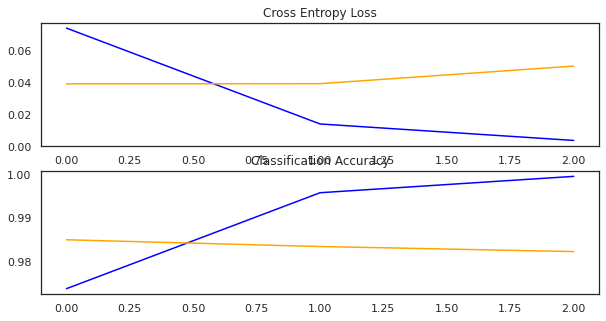

In [100]:
summarize_diagnostics(history)

| Sno | Day      | Architecture | Layers | Batch Size | LR    | Epochs | Optimizer         | Train-Val Split | Augmentation | Regularization | Transfer Learning | Accuracy (Val) | Accuracy (Training) | GPU ? | Time Taken |
|-----|----------|--------------|--------|------------|-------|--------|-------------------|-----------------|--------------|----------------|-------------------|----------------|---------------------|-------|------------|
| 1   | 28/02/21 | Resnet       | 50     | 64         | 0.001 | 20     | Adam              | 0.25            | No           | Low            | No                | 89%            | 98%                 | Yes   | 90s/Epoch  |
| 2   | 28/02/21 | Resnet       | 50     | 32         | 0.001 | 20     | Adam              | 0.1             | No           | Low            | No                | 89.8%          | 92%                 | Yes   | 90s/Epoch  |
| 3   | 28/02/21 | Resnet       | 50     | 32         | 0.001 | 40     | Adam              | 0.1             | No           | Low            | No                | 91.34%         | 99.15%              | Yes   | 90s/Epoch  |
| 4   | 28/02/21 | Resnet       | 50     | 32         | 0.001 | 20     | Adam              | 0.1             | No           | High           | No                | 81.03%         | 94.13%              | Yes   | 90s/Epoch  |
| 5   | 28/02/21 | Resnet       | 50     | 32         | 0.001 | 40     | Adam              | 0.1             | No           | High           | No                | 90.84%         | 99.01%              | Yes   | 90s/Epoch  |
| 6   | 28/02/21 | Resnet       | 50     | 32         | 0.001 | 40     | Adam              | 0.1             | Yes          | High           | No                | 93.78%         | 94.83%              | Yes   | 5min/Epoch |
| 7   | 29/02/21 | Resnet       | 50     | 64         | 0.001 | 3      | SGD with Momentum | 0.1             | No           |                | Yes               | 98.42%         | 99.96%              | Yes   | 135s/Epoch |

In [119]:
test_filenames=os.listdir('./test/test1/')

test_df=pd.DataFrame({
    'filename':test_filenames
})
nb_samples=test_df.shape[0]
test_gen=ImageDataGenerator(featurewise_center=True)
test_gen.mean = [123.68, 116.779, 103.939]

test_generator=test_gen.flow_from_dataframe(test_df,"./test/test1/",x_col='filename',y_col=None, class_mode=None,
                                           target_size=(224,224),batch_size=64,shuffle=False)

Found 12500 validated image filenames.


In [120]:
predict=model.predict(test_generator,steps=np.ceil(nb_samples/64))

In [121]:
predict

array([[9.9981433e-01, 1.8567240e-04],
       [3.4951691e-07, 9.9999964e-01],
       [2.3787141e-11, 1.0000000e+00],
       ...,
       [1.0000000e+00, 2.7335608e-20],
       [1.1402473e-06, 9.9999881e-01],
       [1.0000000e+00, 1.0614678e-18]], dtype=float32)

In [122]:
test_df['category']=np.argmax(predict,axis=-1)

In [123]:
label_map = dict((v,k) for k,v in train_it.class_indices.items())
label_map

{0: 'cats', 1: 'dogs'}

In [124]:
test_df['category'] = test_df['category'].replace(label_map)


In [125]:
test_df['category']=test_df['category'].replace({'cats':0, 
                                                 'dogs':1
})

<AxesSubplot:>

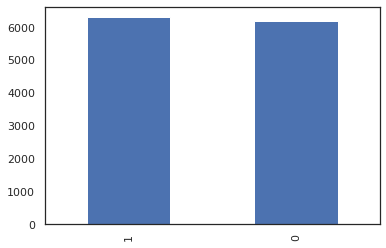

In [126]:
test_df['category'].value_counts().plot(kind='bar')

In [128]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)